# Example 1: Creating benchmarks of MCS Methods

We introduce a public, open-source, Python-based toolbox for benchmarking multi-component signal analysis methods, implemented either in Python or Matlab.

The goal of this toolbox is providing the signal-processing community with a common framework that allows researcher-independent comparisons between methods and favors reproducible research.

With the purpose of making this toolbox more useful, the methods to compare, the tests, the signal generation code and the performance evaluation functions were conceived as different modules, so that one can modify them independently. The only restriction this pose is that the methods should satisfy some requirements regarding the shape of their input and output parameters.

On the one hand, the tests and the performance evaluation functions, are encapsulated in the class `Benchmark`. On the other hand, the signals used in this benchmark are generated by the methods in the class `SignalBank`.

In order to compare different methods with possibly different parameters, we need to set up a few things before running the benchmark. A `Benchmark` object receives some input parameters to configure the test:
- `task`: This could be `'denoising'` or `'detection'`,`'component_denoising'` or `'inst_frequency'`. The first one compute the quality reconstruction factor (QRF) using the output of the method, whereas the second simply consist in detecting whether a signal is present or not. Finally, `'component_denoising'` compares the QRF component wise, and '`inst_frequency'` computes the mean squared error between estimations of the instantaneous frequency
- `N`: The length of the simulation, i.e. how many samples should the signals have.
- `methods`: A dictionary of methods. Each entry of this dictionary corresponds to the function that implements each of the desired methods.
- `parameters`: A dictionary of parameters. Each entry of this dictionary corresponds to iterator with positional and/or keyword arguments. In order to know which parameters should be passed to each method, the keys of this dictionary should be the same as those corresponding to the individual methods in the corresponding dictionary. An example of this is showed in below.
- `SNRin`: A list or tuple of values of SNR to test.
- `repetitions`: The number of times the experiment should be repeated with different realizations of noise.
- `signal_ids`: A list of signal ids (corresponding to the names of the signal in the class '`SignalBank`') can be passed here in order to test the methods on those signals. Optionally, the user can pass a dictionary where each key is used as an identifier, and the corresponding value can be a numpy array with a personalized signal.

## A dummy test 
First let us define a dummy method for testing. Methods should receive a numpy array with shape  ```(N,)``` where `N` is the number of time samples of the signal. Additionally, they can receive any number of positional or keyword arguments to allow testing different combinations of input parameters. The shape of the output depends on the task (signal denoising or detection). So the recommended signature of a method should be the following:

 `output = a_method(noisy_signal, *args, **kwargs) `.

If one set `task='denoising'`, `output` shoud be a `(N,)` numpy array, i.e. the same shape as the input parameter `noisy_signal`, whereas if `task='detection'`, the output should be boolean (`0` or `False` for no signal, and `1` or `True` otherwise).

After this, we need to create a *dictionary of methods* to pass the `Benchmark` object at the moment of instantiation.

In [1]:
import numpy as np
from numpy import pi as pi
import pandas as pd
from matplotlib import pyplot as plt
from mcsm_benchmarks.Benchmark import Benchmark
from mcsm_benchmarks.Benchmark import Benchmark
from mcsm_benchmarks.ResultsInterpreter import ResultsInterpreter

def a_method(noisy_signal, *args, **kwargs):
    # If additional input parameters are needed, they can be passed in a tuple using 
    # *args or **kwargs and then parsed.
    results = noisy_signal # Simply return the same noisy signals.
    return results

def another_method(noisy_signal, *args, **kwargs):
    # If additional input parameters are needed, they can be passed in a tuple using `params` and then parsed.
    results = 2*noisy_signal # Simply return the same noisy signals.
    return results

# Create a dictionary of the methods to test.
my_methods = {
    'Method 1': a_method, 
    'Method 2': another_method,
    }

The variable `params` in the example above allows us to pass some parameters to our method. This would be useful for testing a single method with several combination of input parameters. In order to do this, we should give the `Benchmark` object a *dictionary of parameters*. An example of this functionality is showed in the next section. For now, lets set the input parameter `parameters = None`.

Now we are ready to instantiate a `Benchmark` object and run a test using the proposed methods and parameters. The benchmark constructor receives a name of a task (which defines the performance function of the test), a dictionary of the methods to test, the desired length of the signals used in the simulation, a dictionary of different parameters that should be passed to the methods, an array with different values of SNR to test, and the number of repetitions that should be used for each test. Once the object is created, use the class method `run_test()` to start the experiments.

*Remark 1: You can use the ```verbosity``` parameter to show less or more messages during the progress of the experiments. There are 4 levels of verbosity, from ```verbosity=0``` (indicate just the start and the end of the experiments) to ```verbostiy = 4``` (show each method and parameter progress)*

*Remark 2: Parallelize the experiments is also possible by passing the parameter ```parallelize = True```. *

In [2]:
benchmark = Benchmark(task = 'denoising',
                        methods = my_methods,
                        N = 256, 
                        SNRin = [40, 50], 
                        repetitions = 3,
                        signal_ids=['LinearChirp', 'CosChirp',],
                        verbosity=4, 
                        parallelize=False)
                        
benchmark.run_test() # Run the test. my_results is a dictionary with the results for each of the variables of the simulation.
benchmark.save_to_file('saved_benchmark') # Save the benchmark to a file.

Running benchmark...
- Signal LinearChirp
-- SNR: 40 dB
--- Method: Method 1
---- Parameters Combination: 0
--- Method: Method 2
---- Parameters Combination: 0
-- SNR: 50 dB
--- Method: Method 1
---- Parameters Combination: 0
--- Method: Method 2
---- Parameters Combination: 0
- Signal CosChirp
-- SNR: 40 dB
--- Method: Method 1
---- Parameters Combination: 0
--- Method: Method 2
---- Parameters Combination: 0
-- SNR: 50 dB
--- Method: Method 1
---- Parameters Combination: 0
--- Method: Method 2
---- Parameters Combination: 0
The test has finished.


True

In [3]:
same_benchmark = Benchmark.load_benchmark('saved_benchmark') # Load the benchmark from a file.

Now we have the results of the test in a nested dictionary called `my_results`. In order to get the results in a human-readable way using a `DataFrame`, and also for further analysis and reproducibility, we can use the class method `get_results_as_df()`.

In [4]:
results_df = benchmark.get_results_as_df() # This formats the results on a DataFrame
results_df

,Method,Parameter,Signal_id,Repetition,40,50
6,Method 1,"((), {})",CosChirp,0,39.943871,49.943871
7,Method 1,"((), {})",CosChirp,1,40.023121,50.023121
8,Method 1,"((), {})",CosChirp,2,39.918757,49.918757
0,Method 1,"((), {})",LinearChirp,0,39.943871,49.943871
1,Method 1,"((), {})",LinearChirp,1,40.023121,50.023121
2,Method 1,"((), {})",LinearChirp,2,39.918757,49.918757
9,Method 2,"((), {})",CosChirp,0,-0.020456,-0.006099
10,Method 2,"((), {})",CosChirp,1,-0.017829,-0.005273
11,Method 2,"((), {})",CosChirp,2,-0.001492,-0.000089
3,Method 2,"((), {})",LinearChirp,0,-0.000448,0.000239


As we can see, the DataFrame show the results ordered by columns. The first column corresponds to the method identification, and the values are taken from the keys of the dictionary of methods. The second column enumerates the parameters used (more on this on the next section). The third column corresponds to the signal identification, using the signal identification values from the `SignalBank` class. The next column shows the number of repetition of the experiment. Finally, the remaining columns show the results obtained for the SNR values used for each experiment. Since `task = 'denoising'`, these values correspond to the QRF computed as `QRF = 10*np.log10(E(s)/E(s-sr))`, where `E(x)` is the energy of `x`, and `s` and `sr` are the noiseless signal and the reconstructed signal respectively.

## Passing different parameters to the methods.
It is common that a method depends on certain input parameters (thresholds, multiplicative factors, etc). Therefore, it would be useful that the tests could also be repeated with different parameters, instead of creating multiple versions of one method. We can pass an array of parameters to a method provided it parses them internally. In order to indicate the benchmark which parameters combinations should be given to each method, a dictionary of parameters can be given. 

Let us now create this dictionary. The parameters combinations should be given in a tuple of tuples, so that each internal tuple is passed as the additional parameter (the corresponding method, of course, should implement how to deal with the variable number of input parameters). For this to work, **the keys of this dictionary should be the same as those of the methods dictionary**. 

We can now see more in detail how to pass different parameters to our methods. For instance, let's consider a function that depends on two thresholds `thr1` (a positional argument) and `thr2` (a keyword argument):

In [5]:
def a_function(signal, thr1, thr2=0):
# def a_function(signal, thr1, thr2):
    print(thr1,thr2)    
    signal_out = signal
    signal_out[np.where((thr2>signal) & (signal>thr1))] = 0
    return signal_out

Now let us create a method that wraps the previous function and then define the dictionary of methods for our benchmark. Notice that the method should distribute the parameters in the tuple `params`. 

In [6]:
def another_method(noisy_signal, *args, **kwargs):
    # The method should distribute the parameters accordingly, for example as:
    output = a_function(noisy_signal, *args, **kwargs)
    return output
        

# Create a dictionary of the methods to test.
my_methods = {
    'Method 1': another_method, 
    }

Having done this, we can define the different combinations of parameters using the corresponding dictionary:

In [7]:
# Create a dictionary of the different combinations of thresholds to test:
thr1 = [1.0, 2.0, 3.0] # Positional arguments to try.
thr2 = [4, 5, 6] # Some values for the keyword, argument.

my_parameters = {
    'Method 1': [((t1,),{'thr2': t2,}) for t1 in thr1 for t2 in thr2], # Remember the keys of this dictionary should be same as the methods dictionary.
    # 'Method 1': [{'thr1': t1,'thr2': t2,} for t1 in thr1 for t2 in thr2],
    # 'Method 1': [(t1,t2,) for t1 in thr1 for t2 in thr2],
}

print(my_parameters['Method 1'])

[((1.0,), {'thr2': 4}), ((1.0,), {'thr2': 5}), ((1.0,), {'thr2': 6}), ((2.0,), {'thr2': 4}), ((2.0,), {'thr2': 5}), ((2.0,), {'thr2': 6}), ((3.0,), {'thr2': 4}), ((3.0,), {'thr2': 5}), ((3.0,), {'thr2': 6})]


So now we have four combinations of input parameters for `another_method()`, that will be passed one by one to the method so that all the experiments will be carried out for each of the combinations. Let us set the benchmark and run a test using this new configuration of methods and parameters. After that, we can use the `Benchmark` class method `get_results_as_df()` to obtain a table with the results as before:

In [8]:
benchmark_p = Benchmark(task = 'denoising',
                         methods = my_methods, 
                         N = 256, 
                         parameters = my_parameters, 
                         SNRin = [40, 50],
                         signal_ids=['LinearChirp', 'CosChirp',], 
                         repetitions = 3)

benchmark_p.run_test() # Run the test. my_results is a dictionary with the results for each of the variables of the simulation.
results_parameters = benchmark_p.get_results_as_df() # This formats the results on a DataFrame
results_parameters

Running benchmark...
- Signal LinearChirp
1.0 4
1.0 4
1.0 4
1.0 5
1.0 5
1.0 5
1.0 6
1.0 6
1.0 6
2.0 4
2.0 4
2.0 4
2.0 5
2.0 5
2.0 5
2.0 6
2.0 6
2.0 6
3.0 4
3.0 4
3.0 4
3.0 5
3.0 5
3.0 5
3.0 6
3.0 6
3.0 6
1.0 4
1.0 4
1.0 4
1.0 5
1.0 5
1.0 5
1.0 6
1.0 6
1.0 6
2.0 4
2.0 4
2.0 4
2.0 5
2.0 5
2.0 5
2.0 6
2.0 6
2.0 6
3.0 4
3.0 4
3.0 4
3.0 5
3.0 5
3.0 5
3.0 6
3.0 6
3.0 6
- Signal CosChirp
1.0 4
1.0 4
1.0 4
1.0 5
1.0 5
1.0 5
1.0 6
1.0 6
1.0 6
2.0 4
2.0 4
2.0 4
2.0 5
2.0 5
2.0 5
2.0 6
2.0 6
2.0 6
3.0 4
3.0 4
3.0 4
3.0 5
3.0 5
3.0 5
3.0 6
3.0 6
3.0 6
1.0 4
1.0 4
1.0 4
1.0 5
1.0 5
1.0 5
1.0 6
1.0 6
1.0 6
2.0 4
2.0 4
2.0 4
2.0 5
2.0 5
2.0 5
2.0 6
2.0 6
2.0 6
3.0 4
3.0 4
3.0 4
3.0 5
3.0 5
3.0 5
3.0 6
3.0 6
3.0 6
The test has finished.


,Method,Parameter,Signal_id,Repetition,40,50
3,Method 1,"((1.0,), {'thr2': 4})",CosChirp,0,39.943871,49.943871
4,Method 1,"((1.0,), {'thr2': 4})",CosChirp,1,40.023121,50.023121
5,Method 1,"((1.0,), {'thr2': 4})",CosChirp,2,39.918757,49.918757
0,Method 1,"((1.0,), {'thr2': 4})",LinearChirp,0,39.943871,49.943871
1,Method 1,"((1.0,), {'thr2': 4})",LinearChirp,1,16.723409,50.023121
2,Method 1,"((1.0,), {'thr2': 4})",LinearChirp,2,39.918757,49.918757
9,Method 1,"((1.0,), {'thr2': 5})",CosChirp,0,39.943871,49.943871
10,Method 1,"((1.0,), {'thr2': 5})",CosChirp,1,40.023121,50.023121
11,Method 1,"((1.0,), {'thr2': 5})",CosChirp,2,39.918757,49.918757
6,Method 1,"((1.0,), {'thr2': 5})",LinearChirp,0,39.943871,49.943871


As we can see, the experiments have been repeated for every combination of parameters, listed in the second column of the table as `Parameter`.

## Generating plots with the Results Interpreter.

LinearChirp
CosChirp


/home/juan/Nextcloud/benchmark_standalone/mcsm-benchmarks/mcsm_benchmarks/ResultsInterpreter.py:650: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux.loc[indexes,'Method'] = method_and_params


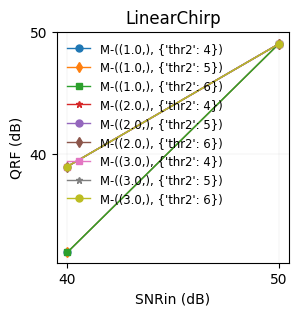

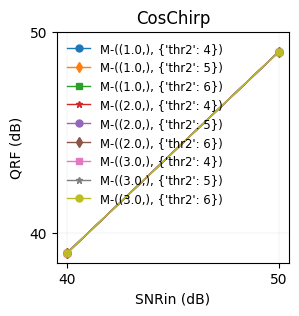

In [9]:
interpreter = ResultsInterpreter(benchmark_p)
fig = interpreter.get_summary_plots(savetofile=False)
plt.show()

interpreter.save_report(filename='report.md',path='.')
